In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import pickle
import random
import os
import gams_magic

## Read files

In [2]:
#read link data
road_file_path = os.path.join('..','road_file.csv')
road_file = pd.read_csv(road_file_path,names=["RDWY_LINK_ID","REF_SITE_FROM_ID","REF_SITE_TO_ID"])

#read shape file
shape_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Middleton_CrossPlains_OVLY.shp")
shape = shapefile.Reader(shape_path)

#read reference point
reference_coordinate = None
reference_path = os.path.join("..","reference_coordinate")

with open(reference_path, 'rb') as f:
    reference_coordinate = pickle.load(f)

## Seasonal/seriousness Model

The crashes are separated according to seasons

In [3]:
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset

In [4]:
%%gams
$title turning network

option limcol = 0, limrow = 0, solprint = off;
set
    nodes
    roadID
    season
    seriousness
;

alias (nodes,i,j);
$gdxin ../turning_network_time.gdx
$loadm nodes=dim1 nodes=dim2
parameter real_distance(nodes,nodes) distance of a road;
$load  real_distance=time
$gdxin


$gdxin ../turning_network_turn.gdx
parameter turn(nodes,nodes) distance of a road;
$load  turn=turn
$gdxin


*display distance;


$gdxin ../turning_network_linkID.gdx
set road(roadID<,i,j);
$load  road=road
$gdxin



$ontext
$gdxin ../crash_file.gdx
parameter  crash(nodes,nodes) number of crashes on a road;
$load  crash=crash
$gdxin
$offtext

$ontext
$gdxin ../crash_seriousness.gdx
$load season=dim3 seriousness=dim4
parameter crashS(nodes,nodes,season,seriousness) number of crashes on a road with different seasons and seriousness;
$load  crashS=serious_crash
$gdxin
$offtext

parameter distance(nodes,nodes);

distance(i,j) = real_distance(i,j);


set arc(nodes,nodes);

arc(i,j) = no;
arc(i,j)$(distance(i,j) > 0.5) = yes;
* adjust the distance
distance(i,j)$(arc(i,j)) = distance(i,j) -1;

parameter
    supply(nodes)
;

scalar origin,destination;
execseed = 1 + gmillisec(jnow);
origin = uniformint(1,card(nodes));
destination = uniformint(1,card(nodes));

*supply(nodes)$(ord(nodes) = origin) = 1;

*supply(nodes)$(ord(nodes) = destination) = -1;

supply('1666494_2') = 1;
supply('1662728_3') = -1;

free variable
    total_dist
;

integer variable
    flow(i,j)
;

flow.lo(i,j) = 0

equation
    balance(nodes)
    objective_shortestPath
    objective_safestPath
    objective_shortestPath2
;


balance(i)..
    sum(arc(i,j), flow(i,j)) - sum(arc(j,i), flow(j,i)) =e= supply(i);
    
objective_shortestPath..
    total_dist =e= sum(arc(i,j),flow(i,j)*turn(i,j));

objective_shortestPath2..
    total_dist =e= sum(arc(i,j),flow(i,j)*distance(i,j) + 0.001*flow(i,j)*turn(i,j));
    



model seasonalPath /balance, objective_shortestPath/;

model seasonalPath2 /balance, objective_shortestPath2/;

solve seasonalPath2 using mip minimizing total_dist;


set roadChosen(roadID);

roadChosen(roadID) = no;

scalar roadChosen2_turn;

roadChosen2_turn = sum(arc(i,j),flow.l(i,j)*turn(i,j));

roadChosen(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosen(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;

*distance(i,j) = turn(i,j);

solve seasonalPath using mip minimizing total_dist;
set roadChosen2(roadID);
scalar roadChosen2_time;

roadChosen2_time = sum(arc(i,j),flow.l(i,j)*real_distance(i,j));

roadChosen2(roadID) = no;

roadChosen2(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosen2(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),1481.4318,3211,9043,MIP,CPLEX,0.23
1,Normal (1),Optimal Global (1),10.0000,3211,9043,MIP,CPLEX,0.118


In [5]:
%gams_pull -d flow
%gams_pull supply
%gams_pull -d road
%gams_pull roadChosen
%gams_pull roadChosen2
%gams_pull roadChosen2_time
%gams_pull roadChosen2_turn

In [8]:
# get the chosen road
chosen_road_safe = []
chosen_road_safe2 = []

for link in roadChosen:
    if "intersection" not in link:
        chosen_road_safe.append(int(link)) 
        
for link in roadChosen2:
    if "intersection" not in link:
        chosen_road_safe2.append(int(link)) 
# get the chosen origin and destination
origin = None
destination = None
for i in supply:
    if i[1] == 1:
        origin = int(i[0].split("_")[0])
    else:
        destination = int(i[0].split("_")[0])                                                                                   

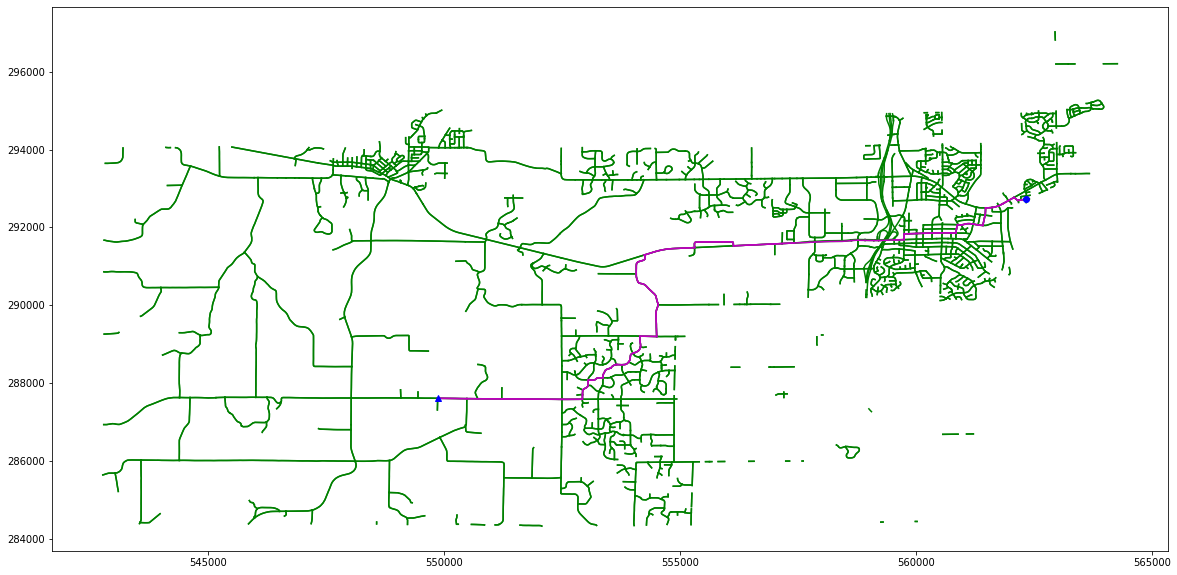

In [18]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()

    
chosen_safe = []
    
#plot original map 
for sp in shape.shapeRecords():
    road_id = sp.record[43]

    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
        
    #record chosen road
    if road_id in chosen_road_safe:
        chosen_safe.append((x,y))
    plt.plot(x,y,'g')
    
#plot saftest path
for subpath in chosen_safe:
    plt.plot(subpath[0],subpath[1],'m')  

plt.plot(reference_coordinate[origin][0], reference_coordinate[origin][1],'b^')
plt.plot(reference_coordinate[destination][0], reference_coordinate[destination][1],'bo')


#plt.set_title(s)
#fig.suptitle('Seasonal Path')


In [17]:
roadChosen

1662728

In [19]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()

    
chosen_safe = []
    
#plot original map 
for sp in shape.shapeRecords():
    road_id = sp.record[43]

    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
        
    #record chosen road
    if road_id in chosen_road_safe2:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_safe.append(segment)
#    plt.plot(x,y,'g')
#    
#plot saftest path
#for subpath in chosen_safe:
#    plt.plot(subpath[0],subpath[1],'m')  

#plt.plot(reference_coordinate[origin][0], reference_coordinate[origin][1],'b^')
#plt.plot(reference_coordinate[destination][0], reference_coordinate[destination][1],'bo')

<Figure size 1440x720 with 0 Axes>

In [20]:
chosen_safe

[[(291692.2009999994, 550892.6660000002),
  (291478.8049999997, 551608.6459999997)],
 [(291478.8049999997, 551608.6459999997),
  (291692.2009999994, 550892.6660000002)],
 [(291626.2809999995, 550868.2139999997),
  (291643.59300000034, 550877.0889999997),
  (291692.2009999994, 550892.6660000002)],
 [(291692.2009999994, 550892.6660000002),
  (291643.59300000034, 550877.0889999997),
  (291626.2809999995, 550868.2139999997)],
 [(293246.2190000005, 556378.8679999998),
  (293246.5, 556399.3679999998),
  (293250.25100000016, 556520.5530000003)],
 [(293223.9600000009, 554239.0350000001),
  (293224.0850000009, 554291.159),
  (293226.0850000009, 554394.9069999997),
  (293226.30399999954, 554480.6550000003),
  (293226.4609999992, 554503.5920000002)],
 [(293250.25100000016, 556520.5530000003),
  (293246.5, 556399.3679999998),
  (293246.2190000005, 556378.8679999998)],
 [(293226.4609999992, 554503.5920000002),
  (293226.30399999954, 554480.6550000003),
  (293226.0850000009, 554394.9069999997),
  (2

In [13]:
roadChosen

['intersection_15',
 'intersection_17',
 'intersection_214',
 'intersection_215',
 'intersection_219',
 'intersection_222',
 'intersection_402',
 'intersection_404',
 'intersection_406',
 'intersection_409',
 'intersection_474',
 'intersection_481',
 'intersection_636',
 'intersection_1082',
 'intersection_1084',
 'intersection_1187',
 'intersection_1190',
 '4820328',
 '4841714',
 'intersection_1365',
 'intersection_1373',
 '4851782',
 '5571402',
 '4830397',
 '5571401',
 'intersection_1430',
 'intersection_1431',
 'intersection_1435',
 'intersection_1438',
 'intersection_1531',
 'intersection_1537',
 '4851783',
 '4830398',
 'intersection_1559',
 'intersection_1562',
 'intersection_1669',
 'intersection_1675',
 'intersection_1741',
 'intersection_1745',
 'intersection_1758',
 'intersection_1859',
 '4841719',
 '4820333',
 'intersection_1914',
 'intersection_1916',
 'intersection_1969',
 'intersection_1971',
 '4820326',
 '4841703',
 '4841712',
 '4820317',
 'intersection_2071',
 'intersect